## EDA - Amazon Buy Box Algo Modelling

In [84]:
import pandas as pd 
import numpy as np
from collections import defaultdict
from matplotlib.ticker import FuncFormatter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

In [51]:
import matplotlib.pyplot as plt

### A. Loading/Cleaning Data

In [ ]:
# loading crawl2 data
crawl2 = pd.read_table("crawl2.txt")

In [ ]:
# read in prime sids and algo seller sids
prime_sids = pd.read_table("prime_sids.txt", header=None, names=["prime_sids"])
algo_sellers = pd.read_table("susp_sids_all_with_amazon.txt", header=None, names=["algo_sids"])

In [ ]:
# rename columns and merge prime/algo lists
crawl2.columns = ["pid", "epoc", "sid", "price", "sid_rating", "sid_pos_fb", "sid_rating_cnt", "shipping", "page", "rank", "pid_rating", "pid_rating_cnt", "is_fba", "is_prime", "bbox_sid", "bbox_price"]
crawl2["prime_seller"] = crawl2["sid"].isin(prime_sids["prime_sids"])
crawl2["algo_seller"] = crawl2["sid"].isin(algo_sellers["algo_sids"])

In [ ]:
# how many unique pids?
unique_pids = crawl2["pid"].unique().tolist()
unique_pids
len(unique_pids)

987

In [77]:
# code for sampling data (for testing code)
sample_ids = np.random.choice(unique_pids, size=400, replace = False)
crawl_data_sample = crawl_data[crawl_data["pid"].isin(sample_ids)]

In [ ]:
# list of pids sorted in descending order by num of sellers
pidsandcount = crawl2.groupby("pid").agg({"pid" : "count"})
pidsandcount.columns = ["count"]
pidsandcount = pidsandcount.reset_index().sort_values(by="count", ascending=False)
pidsandcount.head(5)

,pid,count
600,B009IH0BYQ,30140
255,B001EOV492,30110
159,B000NCOKZQ,30110
681,B00DJPK8PA,30110
63,B0002E1P08,30100


In [ ]:
# copy data and add timestamp column from epoc
crawl_data = crawl2.copy()
crawl_data["timestamp"] = pd.to_datetime(crawl2['epoc'].astype(float), unit='s')
crawl_data

,pid,epoc,sid,price,sid_rating,sid_pos_fb,sid_rating_cnt,shipping,page,rank,pid_rating,pid_rating_cnt,is_fba,is_prime,bbox_sid,bbox_price,prime_seller,algo_seller,timestamp
0,0975277324,1439301853,A19HZ7QWHIRFQA,35.00,0.0,0,0,6.49,1,7,5.0,2321,yes,no,amazon,40.36,False,False,2015-08-11 14:04:13
1,0975277324,1439301853,A1G1QJKXJJSAN2,44.06,5.0,98,3761,3.99,2,9,5.0,2321,no,no,amazon,40.36,False,False,2015-08-11 14:04:13
2,0975277324,1439301853,A1H9LQ4XQ5IZ7D,39.99,5.0,97,1577,0.00,1,1,5.0,2321,yes,yes,amazon,40.36,True,False,2015-08-11 14:04:13
3,0975277324,1439301853,A1OUQ84L1EU4IB,36.99,5.0,100,2,6.49,2,1,5.0,2321,no,no,amazon,40.36,False,False,2015-08-11 14:04:13
4,0975277324,1439301853,A1PSEM5PTWSZBK,39.95,4.5,85,5308,6.10,2,4,5.0,2321,no,no,amazon,40.36,False,False,2015-08-11 14:04:13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20740262,B01387NUN0,1440712515,A8UMA0WO93O39,5.95,5.0,100,3,0.00,1,1,1.0,3,no,no,A8UMA0WO93O39,5.95,False,False,2015-08-27 21:55:15
20740263,B01387NUN0,1440712515,AB62NOZUAODRB,10.99,5.0,100,770,4.75,1,9,1.0,3,no,no,A8UMA0WO93O39,5.95,False,False,2015-08-27 21:55:15
20740264,B01387NUN0,1440712515,AC9XK46ZTUENH,6.00,5.0,100,6,4.50,1,6,1.0,3,no,no,A8UMA0WO93O39,5.95,False,False,2015-08-27 21:55:15
20740265,B01387NUN0,1440712515,AS94HDKW3U98F,10.49,0.0,0,0,0.00,1,5,1.0,3,no,no,A8UMA0WO93O39,5.95,False,False,2015-08-27 21:55:15


### B. Recreating Figure 2 - CDF of Interval Between Changes for Sellers, Buybox Sellers, and Buybox Price

In [48]:
def calculate_inter_update_times(df):
    # group by each product
    product_groups = df.groupby('pid')
    seller_price_update_times = []
    bbox_price_update_times = []
    bbox_seller_update_times = []

    
    for pid, group in product_groups:
        group = group.sort_values('timestamp')
        
        last_price_update = defaultdict(lambda: None)
        last_bbox_price = None
        last_bbox_seller = None
        
        for _, row in group.iterrows():
            timestamp = row['timestamp']
            seller_id = row['sid']
            bbox_price = row['bbox_price']
            bbox_seller = row['bbox_sid']
            
            # calc seller price update time
            if last_price_update[seller_id] is not None:
                time_diff = (timestamp - last_price_update[seller_id]).total_seconds()
                seller_price_update_times.append(time_diff)
            
            # calc buy box price update time
            if last_bbox_price is not None and bbox_price != last_bbox_price:
                time_diff = (timestamp - last_bbox_price[1]).total_seconds()
                bbox_price_update_times.append(time_diff)
                last_bbox_price = (bbox_price, timestamp)
            elif last_bbox_price is None:
                last_bbox_price = (bbox_price, timestamp)
            
            # calc buy box seller update time
            if last_bbox_seller is not None and bbox_seller != last_bbox_seller[0]:
                time_diff = (timestamp - last_bbox_seller[1]).total_seconds()
                bbox_seller_update_times.append(time_diff)
                last_bbox_seller = (bbox_seller, timestamp)
            elif last_bbox_seller is None:
                last_bbox_seller = (bbox_seller, timestamp)
            
            # update last price update time for this seller
            last_price_update[seller_id] = timestamp
    
    return seller_price_update_times, bbox_price_update_times, bbox_seller_update_times

In [ ]:
def plot_cumulative_distribution(seller_times, bbox_price_times, bbox_seller_times, save_path=None):
    seller_times = sorted(seller_times)
    bbox_price_times = sorted(bbox_price_times)
    bbox_seller_times = sorted(bbox_seller_times)
    
    seller_y = np.arange(1, len(seller_times) + 1) / len(seller_times)
    bbox_price_y = np.arange(1, len(bbox_price_times) + 1) / len(bbox_price_times)
    bbox_seller_y = np.arange(1, len(bbox_seller_times) + 1) / len(bbox_seller_times)
    
    fig, ax = plt.subplots()
    
    # convert times from seconds to minutes for plotting
    seller_times_min = [t / 60 for t in seller_times]
    bbox_price_times_min = [t / 60 for t in bbox_price_times]
    bbox_seller_times_min = [t / 60 for t in bbox_seller_times]
    
    # plot cumulative distributions
    ax.plot(seller_times_min, seller_y, 'b-', label='Seller Price Updates')
    ax.plot(bbox_price_times_min, bbox_price_y, 'g-', label='Buy Box Price Updates')
    ax.plot(bbox_seller_times_min, bbox_seller_y, 'r-', label='Buy Box Seller Updates')
    
    # cet log scale for x-axis
    ax.set_xscale('log')
    
    # format y-axis as percentage
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    
    # add labels and title
    ax.set_xlabel('Inter-Update Time (minutes, log scale)')
    ax.set_ylabel('Cumulative Percentage')
    ax.set_title('Figure 2: Cumulative Distribution of Inter-Update Times')
    
    # add grid and legend
    ax.grid(True, alpha=0.3)
    ax.legend(loc='lower right')
    
    # customize x-axis ticks
    time_ticks = [1/60, 1/6, 1, 10, 60, 6*60, 24*60]
    time_labels = ['1s', '10s', '1m', '10m', '1h', '6h', '24h']
    ax.set_xticks(time_ticks)
    ax.set_xticklabels(time_labels)
    
    # set axis limits
    min_time = min(bbox_seller_times_min)
    max_time = max([max(seller_times_min), max(bbox_price_times_min), max(bbox_seller_times_min)])
    ax.set_xlim(min_time * 0.8, max_time * 1.2)
    

In [ ]:
seller_times, bbox_price_times, bbox_seller_times = calculate_inter_update_times(crawl_data)

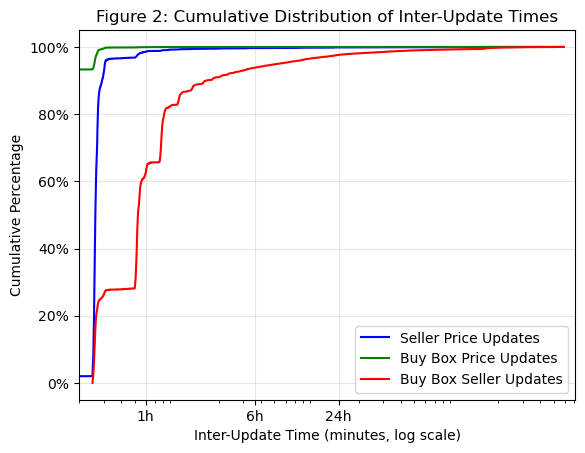

In [99]:
plot_cumulative_distribution(seller_times, bbox_price_times, bbox_seller_times)

### B. Recreating Figure 9 - Probability of Winning Buy Box by Rank

In [78]:
# calculate winrate by rank
crawl_data["wonbbox"] = crawl_data["bbox_sid"] == crawl_data["sid"]
crawl_data_winrate_by_rank = crawl_data.groupby("rank").agg({"wonbbox" : "mean"})
crawl_data_winrate_by_rank

,wonbbox
rank,
0,0.355975
1,0.105770
2,0.051780
3,0.032789
4,0.019421
5,0.014333
6,0.010299
7,0.007691
8,0.006677


Text(0.5, 1.0, 'Probability of Winning Buy Box by Rank')

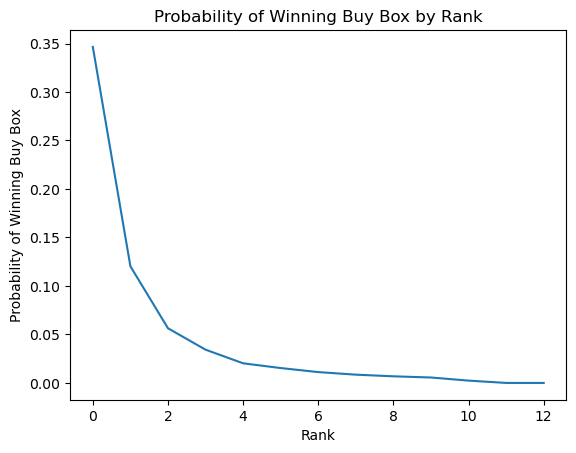

In [ ]:
# plot of winrate by rank
plt.plot(crawl_data_sample_winrate_by_rank.index, crawl_data_sample_winrate_by_rank['wonbbox'], linestyle='-')
plt.xlabel('Rank')
plt.ylabel('Probability of Winning Buy Box')
plt.title('Probability of Winning Buy Box by Rank')

### C. Recreation of RF Classifier - Table 1

In [89]:
crawl_rf = crawl_data
crawl_rf["price_lowest"] = crawl_data.groupby("pid")["price"].transform("min")
crawl_rf["price_difference_to_lowest"] = crawl_rf["price"] - crawl_rf["price_lowest"]
crawl_rf["price_ratio_to_lowest"] = crawl_rf["price"]/crawl_rf["price_lowest"]
crawl_rf["positive_feedback"] = crawl_rf["sid_pos_fb"]
crawl_rf["is_amazon_seller"] = crawl_rf["sid"] == "amazon"
crawl_rf["feedback_count"] = crawl_rf["sid_rating_cnt"]
crawl_rf["average_rating"] = crawl_rf["sid_rating"]
crawl_rf["is_product_fba"] = crawl_rf["is_fba"] == "yes"
#sampling crawl_rf for faster code
rf_sample_ids = np.random.choice(unique_pids, size=200, replace = False)
crawl_rf_sample = crawl_rf[crawl_rf["pid"].isin(rf_sample_ids)]
X = crawl_rf_sample[["price_difference_to_lowest","price_ratio_to_lowest", "positive_feedback","is_amazon_seller","feedback_count", "average_rating","is_product_fba"]]
y = crawl_rf_sample["wonbbox"]

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [91]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.9858
              precision    recall  f1-score   support

       False       0.99      0.99      0.99    761349
        True       0.92      0.88      0.90     58505

    accuracy                           0.99    819854
   macro avg       0.95      0.94      0.95    819854
weighted avg       0.99      0.99      0.99    819854



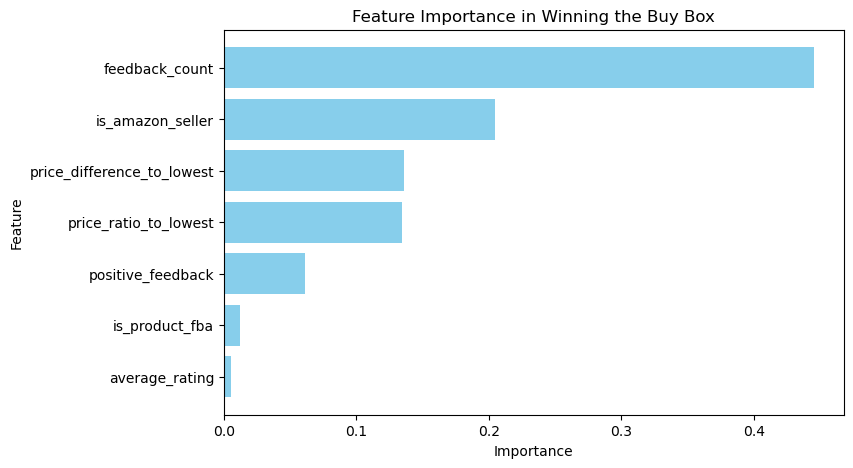

In [94]:
feature_importances = rf_classifier.feature_importances_
importance_df = pd.DataFrame({'Feature': ["price_difference_to_lowest","price_ratio_to_lowest", "positive_feedback","is_amazon_seller","feedback_count", "average_rating","is_product_fba"], 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(8, 5))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Winning the Buy Box")
plt.gca().invert_yaxis()
plt.show()

### D. Recreating Product-Wise Price to find instances of price matching

In [101]:
unique_pids


['0975277324',
 'B00000J0RJ',
 'B00000JBNX',
 'B00002ND64',
 'B00004R9TL',
 'B00004RBDU',
 'B00004RIZ7',
 'B00004S7V8',
 'B00004SQLJ',
 'B00004TZY8',
 'B00004U9JO',
 'B00004UBGZ',
 'B00004UE29',
 'B00004YO15',
 'B00004YTJE',
 'B00004Z4A8',
 'B00004Z4CP',
 'B00004Z5SM',
 'B000052XHI',
 'B00005BXKM',
 'B00005O6B7',
 'B000067EH7',
 'B000067PCE',
 'B000067PQ0',
 'B000068O36',
 'B000068O3C',
 'B000068PBT',
 'B00006ANDK',
 'B00006I551',
 'B00006IBYA',
 'B00006IDV8',
 'B00006IEE4',
 'B00006IEEU',
 'B00006IEJC',
 'B00006IESK',
 'B00006IFAV',
 'B00006IFH0',
 'B00006IFKU',
 'B00006IUWA',
 'B00006JNN7',
 'B00006WNMJ',
 'B00008Y0VN',
 'B000096QQ5',
 'B00009IMCK',
 'B00009PGNT',
 'B0000AQOH2',
 'B0000AXRH5',
 'B0000CBK1L',
 'B0000YNR4M',
 'B0000YUXI0',
 'B00012YIA0',
 'B00016XJ4M',
 'B000197NXM',
 'B0001DSIVY',
 'B0001J3R3C',
 'B00026ZEDK',
 'B00028XJNA',
 'B00029WYEY',
 'B0002CZW0Y',
 'B0002D0CA8',
 'B0002D0CAI',
 'B0002D0HXA',
 'B0002E1G5C',
 'B0002E1P08',
 'B0002E7DIQ',
 'B0002FOBJY',
 'B0002GLC